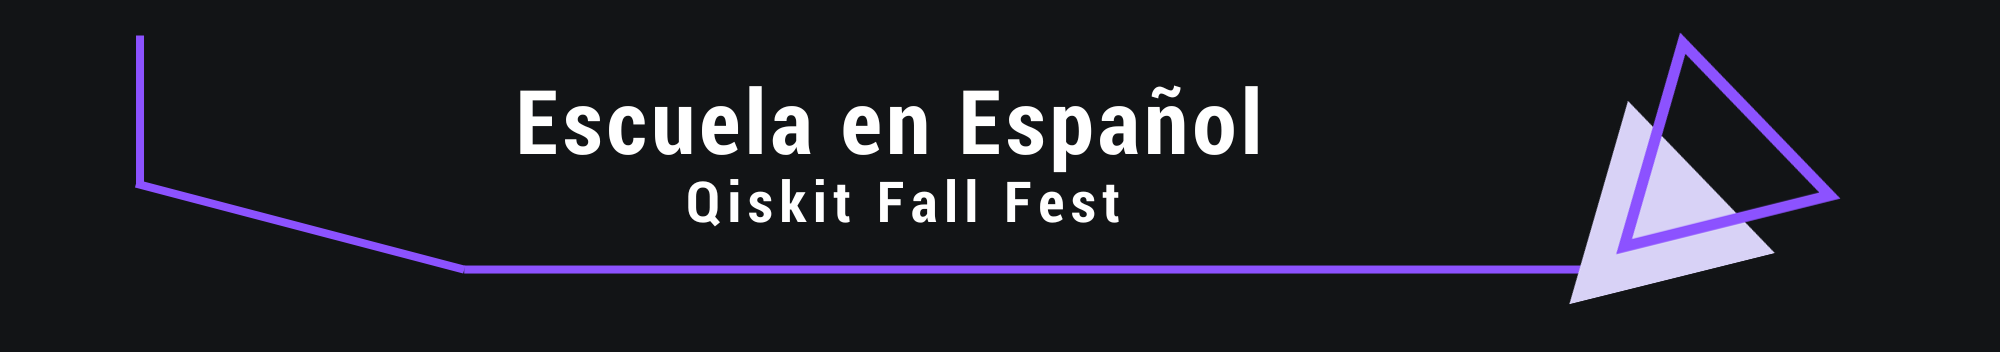

<h1>Ejercicio 4: Optimización</h1>

<p style="font-size:xx-large;">Problema del rendimiento de cultivos</p>

En este desafío estarás expuesto, a un alto nivel, a la computación cuántica a través de Qiskit. Como usuarios actuales o futuros de las computadoras cuánticas, necesitan saber qué problemas son apropiados para la computación cuántica, cómo estructurar el modelo/las entradas del problema para que sean compatibles con el algoritmo elegido y cómo ejecutar un algoritmo y una solución cuántica determinados para resolver el problema.

## Inicialización

Para asegurarte de que las demostraciones y los ejercicios tengan los módulos y bibliotecas de Python necesarios, ejecuta la siguiente celda antes de continuar.

In [ ]:
# Instala Qiskit Optimization, si aún no lo tienes
#!pip install qiskit-optimization

In [ ]:
# Instala Qiskit Algorithms, si aún no lo tienes
#!pip install qiskit_algorithms

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Importar Qiskit
from qiskit.algorithms.minimum_eigensolvers import QAOA, SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

## Contenido

1. Inicialización
2. Contenido
3. Módulo: Qiskit Optimization
5. Problemas Cuadráticos (Quadratic Problems)
6. El problema del rendimiento de cultivos como problema cuadrático
7. Resolver el problema del rendimiento de cultivos con Computación Cuántica
8. Simular una Computadora Cuántica real para el problema del rendimiento de cultivos

## Módulo: Qiskit Optimization

En este cuaderno, usaremos el módulo de aplicaciones `Qiskit Optimization` para un problema específico para ilustrar cómo

1. las definiciones de problemas clásicos y matemáticos están representados en Qiskit,
2. se definen algunos algoritmos cuánticos,
3. ejecutar un algoritmo cuántico para una definición dada de un problema,
4. y los algoritmos y problemas de Qiskit se ejecutan en computadoras cuánticas reales y simuladas.

También utilizaremos Qiskit Terra, ya que proporcionan la base para Qiskit.

## Problemas Cuadráticos (Quadratic Problems)

Algunos problemas computacionales se pueden formular en ecuaciones cuadráticas de modo que el mínimo de las ecuaciones cuadráticas sea la solución óptima, si existe alguna. Estos problemas se encuentran en finanzas, agricultura, gestión de operaciones y producción, y economía.

La programación cuadrática también se utiliza para identificar una cartera financiera óptima con un riesgo mínimo, y optimizar el diseño de los componentes de producción en una fábrica para minimizar la distancia de viaje de los recursos. Este notebook se centra en la agricultura, ya que es una aplicación relevante de la computación cuántica a los problemas que enfrenta el mundo. Sin embargo, todas estas aplicaciones comparten dos características comunes: el sistema se puede modelar como una ecuación cuadrática y las variables del sistema pueden restringirse, con sus valores limitados dentro de un rango determinado.

---

Los problemas cuadráticos adoptan la siguiente estructura. Dado un vector de $n$ variables $x\in\mathbb{R}^n$, la función cuadrática a minimizar es la siguiente.

$$
\begin{align}
\text{minimizar}\quad & f\left(x\right)=\frac{1}{2}x^\top{}\mathbf{Q}x + c^\top{}x &\\
\text{sujeto a}\quad & \mathbf{A}x\leq{}b&\\
& x^\top{}\mathbf{Q}_ix + c_{i}^\top{}x\leq{}r_i,\quad&\forall{}i\in[1,k_q]\\
& l_i\leq{}x_i\leq{}u_i,\quad&\forall{}i\in[1,k_l]\\
\end{align}
$$

$\mathbf{Q}$, $\mathbf{Q}_i$, y $\mathbf{A}$ son matrices simétricas de $n\times{}n$. $c$ and $c_i$ son vectores columna de $n\times{}1$. $\mathbf{Q}_i$, $\mathbf{A}$, $c_i$, $l_i$, y $u_i$ definen restricciones sobre las variables en $x$. La ecuación cuadrática central del problema cuadrático se encuentra multiplicando las matrices en la función de minimización. Aunque se usa '$\leq{}$' en las ecuaciones de restricción anteriores, se puede usar cualquier relación de identidad para cualquier número de restricciones: es decir, "$<$", "$=$", "$>$", "$\geq$", or "$\leq$".

Una solución válida debe satisfacer todas las condiciones del problema. A continuación se dan ejemplos de algunas restricciones. Las dos primeras son restricciones lineales, mientras que el tercer ejemplo es una restricción cuadrática.

$$ x_1 + x_4 \leq{} 10$$

$$ x_2 - 3x_6 = 10$$

$$x_1x_2 - 4x_3x_4 + x_5 \leq{} 15 $$


Qiskit tiene código Python que te permite implementar un problema cuadrático como una instancia de `QuadraticProgram`. Aunque nuestra definición anterior utilizó matrices para definir los coeficientes, `QuadraticProgram` te permite definir el objetivo (función sobre la cual minimizar) directamente. Para ilustrar cómo usar `QuadraticProgram`, usaremos la siguiente definición de problema cuadrático, con tres variables enteras.

$$\begin{align}
\text{minimizar}\quad{} & f(x)=(x_1)^2 + (x_2)^2 - x_1x_2 - 6x_3 \\
\text{sujeto a}\quad{} & x_1 + x_2 = 2             \\
                         & x_2x_3 \geq{} 1           \\
                         & -2 \leq{} x_2 \leq{} 2    \\
                         & -2 \leq{} x_3 \leq{} 4    \\
\end{align}$$

La siguiente figura muestra las restricciones de $x_1$ y $x_3$, con cierta simplificación. El área sombreada indica valores válidos para $x_1$ y $x_3$, dentro de los cuales se debe minimizar $f(x)$.

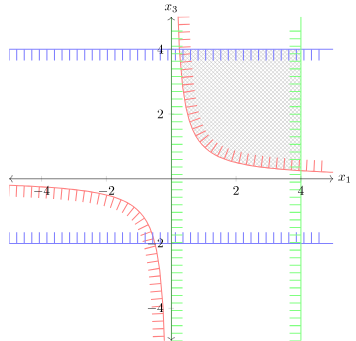

En el siguiente código, el problema cuadrático anterior se define como una instancia de `QuadraticProgram`. Echa un vistazo a la [documentación de Qiskit para `QuadraticProgram`](https://qiskit.org/ecosystem/optimization/stubs/qiskit_optimization.QuadraticProgram.html), ya que puede resultar muy útil para ayudarte a comprender su interfaz.

La ecuación cuadrática a minimizar, llamada objetivo, se implementa mediante diccionarios. Esto te permite a tí, el desarrollador, definir explícitamente coeficientes para variables y términos específicos. Las claves en los diccionarios son los nombres de las variables que identifican un término en $f(x)$. Por ejemplo, `("x_1","x_2")` es para $x_1x_2$. Los valores de cada elemento son los coeficientes de dichos términos. Los términos que se restan en $f(x)$ deben tener un coeficiente negativo.

In [ ]:
quadprog = QuadraticProgram(name="ejemplo 1")
quadprog.integer_var(name="x_1", lowerbound=0, upperbound=4)
quadprog.integer_var(name="x_2", lowerbound=-2, upperbound=2)
quadprog.integer_var(name="x_3", lowerbound=-2, upperbound=4)
quadprog.minimize(
    linear={"x_3": -6},
    quadratic={("x_1", "x_1"): 1, ("x_2", "x_2"): 1, ("x_1", "x_2"): -1},
)
quadprog.linear_constraint(linear={"x_1": 1, "x_2": 1}, sense="=", rhs=2)
quadprog.quadratic_constraint(quadratic={("x_2", "x_3"): 1}, sense=">=", rhs=1)

Un `QuadraticProgram` puede tener tres tipos de variables: binaria, entera y continua. La implementación en Qiskit de los algoritmos que vamos a utilizar actualmente solo admite variables binarias y enteras. Existen otros algoritmos que permiten la simulación de variables continuas, pero no se tratan en este notebook. Sin embargo, si deseas saber más sobre esto, consulta este tutorial de Qiskit sobre [algoritmos para resolver problemas cuadráticos de variables mixtas](https://qiskit.org/ecosystem/optimization/locale/es_UN/tutorials/05_admm_optimizer.html).

Podemos visualizar el `QuadraticProgram` como una cadena LP, un formato portable basado en texto que se utiliza para representar el modelo como un problema de **P**rogramación **L**ineal.

In [ ]:
print(quadprog.export_as_lp_string())

Cualquier problema de optimización que pueda representarse como una única ecuación de segundo orden, en la que el máximo exponente de cualquier término sea 2, puede transformarse en un problema o programa cuadrático de la forma dada anteriormente. El ejemplo anterior es arbitrario y no necesariamente representa un problema determinado del mundo real. El problema principal de este notebook se centra en optimizar el rendimiento de una granja, aunque sólo es necesario cambiar la definición del problema para aplicar esta técnica a otras aplicaciones de problemas cuadráticos.

## El problema del rendimiento de cultivos como problema cuadrático

Para mostrar cómo resolver tu programa cuadrático usando una computadora cuántica, usaremos dos algoritmos para resolver el problema de rendimiento de cultivos. Es una necesidad común optimizar los cultivos y la gestión de una explotación para reducir el riesgo y al mismo tiempo aumentar las ganancias. Uno de los grandes desafíos que enfrenta el mundo entero es cómo producir suficientes alimentos para todos. El problema aquí no se centra en las ganancias sino en el tonelaje de cultivos cosechados. Imagina que tienes una finca con tres hectáreas de terreno apto para la agricultura. Debes elegir qué cultivos plantar entre una selección de cuatro. Además, también debes determinar cuántas hectáreas de cada uno debes plantar. Los cuatro cultivos que puedes plantar son trigo, frijol de soya, maíz y un cultivo *push-pull*. El cuarto no se puede vender una vez cosechado, pero puede ayudar a aumentar el rendimiento de los demás cultivos.

<table>
    <tr>
        <th>
            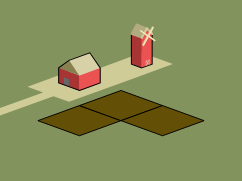
        </th>
    </tr>
    <tr>
        <th>
            Nuestra hermosa finca de tres hectáreas
        </th>
    </tr>
</table>

<table>
    <tr>
        <th>
        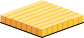
        </th>
        <th>
            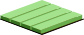
        </th>
        <th>
            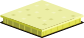
        </th>
        <th>
            
        </th>
    </tr>
    <tr>
        <th>
            Trigo
        </th>
        <th>
            Frijol de soya
        </th>
        <th>
            Maíz
        </th>
        <th>
            Push-Pull
        </th>
    </tr>
</table>

Hay tres tipos de métodos agrícolas que podemos utilizar: monocultivo, cultivo intercalado y agricultura push-pull. Estos se muestran a continuación. Monocultivo es aquel en el que sólo se cultiva un cultivo. Esto puede hacer que la granja sea susceptible a enfermedades y plagas, ya que todo el rendimiento se vería afectado. En algunos casos, cultivar dos plantas diferentes una cerca de la otra aumentará el rendimiento de ambas, aunque a veces puede disminuirlo. El cultivo intercalado es el proceso en el que se eligen diferentes plantas para aumentar el rendimiento. Los cultivos push-pull son pares de plantas que repelen plagas y atraen plagas respectivamente. Integrarlos en una finca más grande aumenta el rendimiento de los alimentos cosechados pero con el costo de no necesariamente poder utilizar la cosecha de cultivos Push-Pull como parte del rendimiento total. Esto se debe a que es posible que el cultivo Push-Pull no sea utilizable o incluso comestible.

<table>
    <tr>
        <th>
        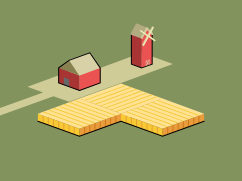
        </th>
        <th>
            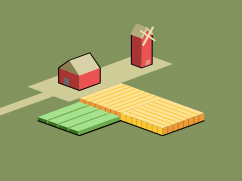
        </th>
        <th>
            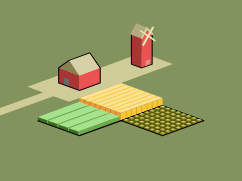
        </th>
    </tr>
    <tr>
        <th>
            Monocultivo
        </th>
        <th>
            Cultivo intercalado
        </th>
        <th>
            Agricultura Push-Pull
        </th>
    </tr>
</table>

---
Sólo en determinados casos, los problemas de programación cuadrática se pueden resolver fácilmente utilizando problemas clásicos. En su sentido general, son NP-Hard; una clase de problemas que es difícil de resolver utilizando métodos computacionales clásicos. De hecho, el mejor método clásico para resolver estos problemas implica la heurística, una técnica que encuentra una solución aproximada. Se ha demostrado que las computadoras cuánticas proporcionan una velocidad significativa y un mejor escalamiento para algunos problemas heurísticos. El problema del rendimiento de los cultivos es un problema combinatorio, en el sentido de que la solución es una combinación específica de parámetros de entrada. Aunque el problema que se muestra aquí es lo suficientemente pequeño como para resolverlo de manera clásica, los problemas más grandes se vuelven intratables en una computadora clásica debido a la cantidad de combinaciones que se deben optimizar.

Resolver el problema anterior utilizando computación cuántica implica tres componentes:

1. Definir el problema
2. Definir el algoritmo
3. Ejecutar el algoritmo en un backend

Muchos problemas en Qiskit siguen esta estructura, ya que el algoritmo que utilizas generalmente se puede cambiar por otro sin redefinir significativamente tu problema. La ejecución en diferentes backends es la más sencilla, siempre que el dispositivo tenga recursos suficientes.

### Definir el problema del rendimiento de cultivos

El siguiente problema está definido para tí, pero el `QuadraticProgram` no está implementado. Tu tarea al final de esta sección es implementar el `QuadraticProgram` para el modelo de rendimiento de cultivos dado.

Tu finca tiene tres hectáreas disponibles, $3~ha$, y cada cultivo ocupa $0~ha$ o $1~ha$. Definimos el rendimiento de la finca como una función cuadrática donde la influencia de cada cultivo entre sí, está representada por coeficientes cuadráticos. Las variables en esta ecuación cuadrática son el número de hectáreas del cultivo a sembrar y la función objetivo a maximizar es el rendimiento de cultivos aprovechables en toneladas. Aquí está el modelo matemático del problema. En este escenario, todos los cultivos aumentan el rendimiento de otros cultivos. Sin embargo, el problema a resolver es encontrar qué cultivos utilizar para lograr el máximo rendimiento.

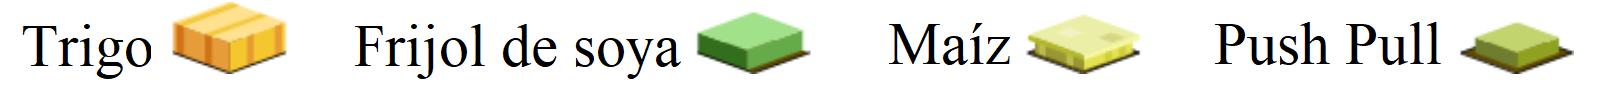

The farm yield, in tons, is modelled as a quadratic equation, given below, with constraints on the hectares used by each crop and the total hectares available. Each crop is shown using a different symbol, as shown above, representing the number of hectares to be planted of said plant. Note that we can only plant up to 1 hectare of each crop and that our farm is constrained to 3 hectares.

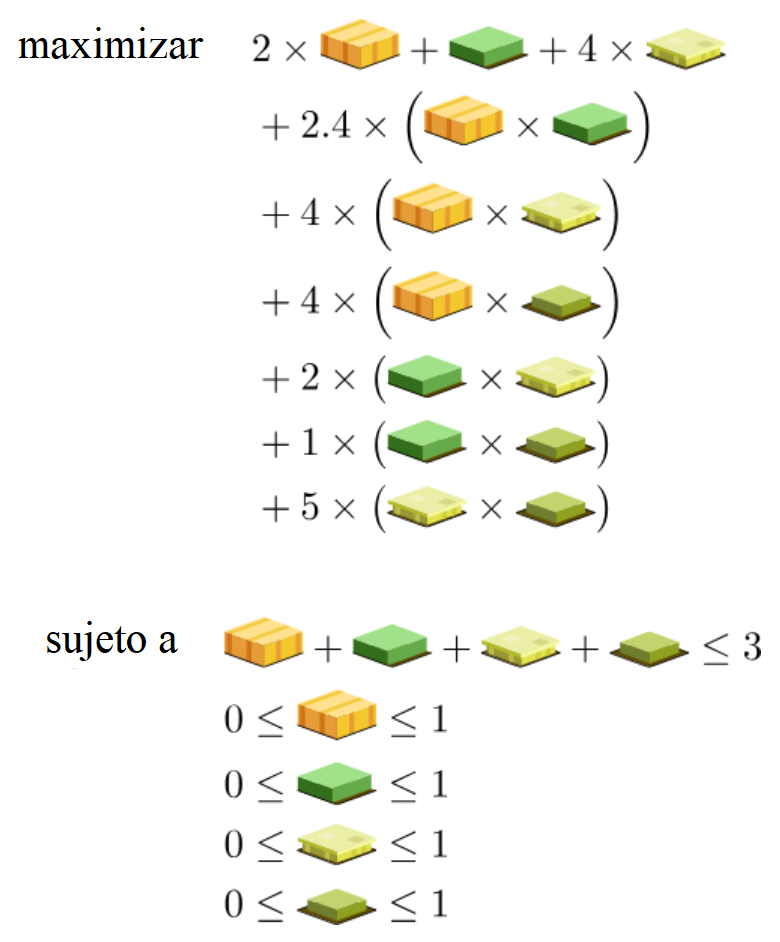

----
#### Notación no gráfica
Aquí hay una representación no gráfica del modelo anterior,

$$
\begin{align}
    \text{maximizar} \quad & 2(\operatorname{Trigo}) + \operatorname{Soya} + 4(\operatorname{Maiz}) \\
    & + 2.4(\operatorname{Trigo}\times\operatorname{Soya}) \\ & + 4(\operatorname{Trigo}\times\operatorname{Maiz})\\
    &+ 4(\operatorname{Trigo}\times\operatorname{PushPull}) \\ & + 2(\operatorname{Soya}\times\operatorname{Maiz}) \\
                          & + (\operatorname{Soya}\times\operatorname{PushPull}) \\ & + 5(\operatorname{Maiz}\times\operatorname{PushPull})
\end{align}
$$

$$
\begin{align}
\text{sujeto a} \quad & \operatorname{Trigo} + \operatorname{Soya} + \operatorname{Maiz} + \operatorname{PushPull} \leq{} 3\\
& 0\leq{}\operatorname{Trigo}\leq{}1\\
& 0\leq{}\operatorname{Soya}\leq{}1\\
& 0\leq{}\operatorname{Maiz}\leq{}1\\
& 0\leq{}\operatorname{PushPull}\leq{}1
\end{align}
$$

### Ejercicio: Cree un programa cuadrático a partir de las variables de rendimiento de cultivos

Tu primer ejercicio es crear un `QuadraticProgram` que represente el modelo anterior. Escribe tu implementación en la función `cropyield_quadratic_program` de abajo. Recuerda utilizar el ejemplo como guía y consultar la [documentación de QuadraticProgram](https://qiskit.org/ecosystem/optimization/locale/es_UN/tutorials/01_quadratic_program.html) y la [referencia de Qiskit](https://qiskit.org/ecosystem/optimization/stubs/qiskit_optimization.QuadraticProgram.html).

**Nota:** Asegúrate de que tus variables se llamen `Trigo`, `Soya`, `Maiz,` y `PushPull`.

In [ ]:
def cropyield_quadratic_program():
    cropyield = QuadraticProgram(name="Rendimiento de cultivos")
    ##############################
    # Coloca tu implementación aquí
    
    #
    ##############################
    return cropyield

In [ ]:
print(cropyield_quadratic_program().export_as_lp_string())

### Convertir a QuadraticPrograms

Si queremos estimar cuántos qubits requiere este programa cuadrático, podemos convertirlo a un modelo Ising e imprimir el parámetro `num_qubits`. Un [modelo ising](https://qiskit.org/documentation/stable/0.24/apidoc/qiskit.optimization.applications.ising.html) es un tipo especial de modelo de sistema que es muy adecuado para la computación cuántica. Aunque no usaremos un modelo ising explícitamente, los algoritmos y las clases de Qiskit que usamos realizan esta conversión internamente.

In [ ]:
# Estimar el número de qubits necesarios

cropyield = cropyield_quadratic_program()

ising_operations, _ = (
    QuadraticProgramToQubo()
    .convert(
        cropyield,
    )
    .to_ising()
)

print(f"El número de qubits necesarios es {ising_operations.num_qubits}")

Aunque los programas cuadráticos se utilizan ampliamente en Qiskit, los algoritmos que vamos a utilizar requieren variables binarias. Qiskit proporciona un método automatizado para convertir nuestras variables enteras en variables binarias. La forma solo binaria se denomina problema de _Optimización binaria cuadrática sin restricciones_ o `QUBO` (Quadratic Unconstrained Binary Optimization). La conversión se realiza utilizando `QuadraticProgramToQUBO` del módulo de optimización de Qiskit. Cada variable entera y sus restricciones asociadas se transforman en variables binarias.

Ejecuta el siguiente código para ver cómo se ve la versión QUBO del problema de rendimiento de cultivos. Observa cómo la ecuación cuadrática se vuelve más larga y se agregan más variables. Esto es para tener en cuenta los bits de cada variable, incluidas las restricciones. Cuando ejecutamos nuestro algoritmo cuántico para resolver este programa cuadrático, se convierte implícitamente en una instancia de QUBO dentro de la implementación del algoritmo en Qiskit.

In [ ]:
QuadraticProgramToQubo().convert(cropyield)

## Resolver el problema del rendimiento de cultivos con Computación Cuántica

Hay tres formas de _ejecutar_ un algoritmo cuántico usando Qiskit:
1. en un simulador local entsu propiacomputadoraa
2. en un simulador alojado en la nube por IBM
3. en una computadora cuántica real accesible a través de IBM QuantumTodos estos se denominan backends. En todos los casos, el _backend_ se puede cambiar fácilmente por otro siempre que el simulador o dispositivo tenga los recursos adecuados (número de qubits, etc.).es.

Nos gustaría comparar nuestra solución cuántica con la obtenida clásicamente. En segundo lugar, también queremos probar diferentes algoritmos. Las siguientes tres subsecciones muestran cómo se implementan en Qiskit estos diferentes métodos para resolver el problema de rendimiento de cultivos. Los dos algoritmos utilizados son el [_Algoritmo Cuántico de Optimización Aproximada_](https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.QAOA.html) `QAOA` (Quantum Approximate Optimization Algorithm) y el [_Solucionador Propio Variacional Cuánico_](https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.VQE.html) `VQE` (Variational Quantum Eigensolver).

Ambos algoritmos son híbridos, ya que utilizan un optimizador clásico para alterar los parámetros que afectan el cálculo cuántico. El algoritmo VQE se utiliza para encontrar el valor propio más bajo de una matriz, que puede describir un sistema a optimizar. El QAOA también encuentra el valor propio más bajo, pero lo logra de una forma diferente a la del VQE. Ambos son algoritmos muy populares, con diferentes aplicaciones y fortalezas.

### Solución clásica

La solución clásica al problema del rendimiento de cultivos se puede encontrar fácilmente utilizando Numpy y Qiskit. El problema QUBO se puede resolver encontrando el valor propio mínimo de su representación matricial subyacente. Afortunadamente, no necesitamos saber cómo es esta matriz. Solo necesitamos pasarlo a `MinimumEigensolver` y `MinimumEigenOptimizer`.

El optimizador traduce el problema proporcionado en una representación parametrizada que luego se pasa al solucionador. Al optimizar los parámetros, el solucionador eventualmente dará el valor propio mínimo para la representación parametrizada y, por lo tanto, la solución al problema original. Aquí utilizamos un solucionador clásico de NumPy, el `NumPyMinimumEigensolver`.

In [ ]:
def get_classical_solution_for(quadprog: QuadraticProgram):
    # Crear el solucionador
    solver = NumPyMinimumEigensolver()

    # Crear optimizador para el solucionador
    optimizer = MinimumEigenOptimizer(solver)

    # Devolver el resultado del optimizador
    return optimizer.solve(quadprog)

Si ejecutamos el método clásico para nuestro problema de rendimiento de cultivos, obtenemos una solución válida que maximiza el rendimiento.

In [ ]:
# Obtener el resultado clásico
classical_result = get_classical_solution_for(cropyield)

# Formatear e imprimir el resultado
print("Solución encontrada usando el método clásico.:\n")
print(f"El rendimiento máximo del cultivo es {classical_result.fval} toneladas")
print(f"Los cultivos utilizados son: ")

_crops = [v.name for v in cropyield.variables]
for cropIndex, cropHectares in enumerate(classical_result.x):
    print(f"\t{cropHectares} ha de {_crops[cropIndex]}")

### Solución con QAOA

Para resolver nuestro problema usando QAOA, solo necesitamos reemplazar el solucionador clásico con una instancia de la clase `QAOA`. Ahora que estamos ejecutando un algoritmo cuántico, debemos indicarle al solucionador dónde ejecutar el componente cuántico. En esta ocasión usamos una instancia de `Sampler`. El QAOA es un algoritmo iterativo y, por lo tanto, se ejecuta varias veces con diferentes parámetros internos. Los parámetros se ajustan de forma clásica durante el paso de optimización del cálculo mediante el `optimizer`, para el cual usaremos `COBYLA`. Para determinar cuántas iteraciones hay, definimos una función de devolución de llamada que se ejecuta para cada iteración y almacena el número de evaluaciones hasta el momento. Al final de la ejecución de nuestro algoritmo, devolvemos el resultado y el número de iteraciones.

In [ ]:
def get_QAOA_solution_for(
    quadprog: QuadraticProgram, sampler, optimizer,
):
    _eval_count = 0

    def callback(eval_count, parameters, mean, std):
        nonlocal _eval_count
        _eval_count = eval_count
    
    # Crear el solucionador
    solver = QAOA(
        sampler, optimizer=optimizer, callback=callback,
    )

    # Crear optimizador para el solucionador
    optimizer = MinimumEigenOptimizer(solver)

    # Obtener el resultado del optimizador
    result = optimizer.solve(quadprog)
    return result, _eval_count

Si ejecutamos el método QAOA para nuestro problema de rendimiento de cultivos, obtenemos el mismo resultado que el método clásico, mostrando que 1) la solución cuántica es correcta y 2) ¡que ahora sabes cómo usar un algoritmo cuántico! 🌟

In [ ]:
# Obtener el resultado con QAOA
qaoa_result, qaoa_eval_count = get_QAOA_solution_for(cropyield, Sampler(), COBYLA())

# Formatear e imprimir el resultado
print("Solución encontrada usando el método QAOA:\n")
print(f"El rendimiento máximo del cultivo es {qaoa_result.fval} toneladas")
print(f"Los cultivos utilizados son: ")
for cropHectares, cropName in zip(qaoa_result.x, qaoa_result.variable_names):
    print(f"\t{cropHectares} ha de {cropName}")

print(f"\nLa solución fue encontrada en {qaoa_eval_count} evaluaciones de QAOA.")

### Solución con VQE

El algoritmo `VQE` funciona de forma muy similar al `QAOA`. No solo desde una perspectiva algorítmica y de modelado matemático, sino también programáticamente. Hay un solucionador cuántico y un optimizador clásico. La instancia de `SamplingVQE` también es iterativa, por lo que podemos medir cuántas iteraciones se necesitan para encontrar una solución al problema de rendimiento de cultivos. En este caso es necesario un ansatz, para lo cual usaremos una instancia de `TwoLocal`.

In [ ]:
def get_VQE_solution_for(
    quadprog: QuadraticProgram, sampler, optimizer,
):
    _eval_count = 0

    def callback(eval_count, parameters, mean, std):
        nonlocal _eval_count
        _eval_count = eval_count

    # Crerar un anstz, necesatio para VQE
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    
    # Crear el solucionador
    solver = SamplingVQE(
        sampler, ansatz, optimizer=optimizer, callback=callback
    )

    # Crear optimizador para el solucionador
    optimizer = MinimumEigenOptimizer(solver)

    # Obtener el resultado del optimizador
    result = optimizer.solve(quadprog)
    return result, _eval_count

Y deberíamos obtener exactamente la misma respuesta que antes.

In [ ]:
# Obtener el resultado con VQE
vqe_result, vqe_eval_count = get_VQE_solution_for(cropyield, Sampler(), COBYLA())

# Formatear e imprimir el resultado
print("Solución encontrada usando el método VQE:\n")
print(f"El rendimiento máximo del cultivo es {vqe_result.fval} toneladas")
print(f"Los cultivos utilizados son: ")
for cropHectares, cropName in zip(vqe_result.x, vqe_result.variable_names):
    print(f"\t{cropHectares} ha de {cropName}")

print(f"\nLa solución fue encontrada en {vqe_eval_count} evaluaciones de VQE")

_Siempre puedes verificar tu resultado con el método clásico, aunque esto sólo es posible aquí dada la magnitud del problema. Los problemas más grandes se vuelven más difíciles de verificar._

## En el siguiente enlace encontrarás el formulario para subir la respuesta de tu trabajo, recuerda que solo debes contestar una vez: https://forms.gle/idVnqX8jy4C9LJv47